# CS 565 Analysis - StackOverflow Newcomers

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display
import plotly.express as px

nc = pd.read_csv('newcomers.csv')

nc['FirstPostDate'] = pd.to_datetime(nc['FirstPostDate'])
nc['AccountCreationDate'] = pd.to_datetime(nc['AccountCreationDate'])
nc['Lurking'] = (nc['FirstPostDate'] - nc['AccountCreationDate']).dt.days

nc['AvgUpVotes'] = nc['TotalUpVotes'] / nc['NumInitialPosts']
nc['AvgDownVotes'] = nc['TotalDownVotes'] / nc['NumInitialPosts']
nc['AvgOtherPositive'] = nc['TotalOtherPositive'] / nc['NumInitialPosts']
nc['AvgOtherNegative'] = nc['TotalOtherNegative'] / nc['NumInitialPosts']

nc['AvgNumEdits'] = nc['TotalSuggestedEdits'] / nc['NumInitialPosts']

nc['Retained'] = (nc['NumFuturePosts'] > 0).astype(int)

## Descriptive Statistics

In [2]:
nc.dtypes

UserId                          int64
AccountCreationDate    datetime64[ns]
FirstPostDate          datetime64[ns]
NumInitialPosts                 int64
NumQuestions                    int64
AvgViewCount                  float64
AvgNumAnswers                 float64
AvgTopAnswererRep             float64
AvgTopAnswererAge             float64
TotalSuggestedEdits             int64
AvgEditorRep                  float64
AvgEditorAge                  float64
TotalUpVotes                    int64
TotalDownVotes                  int64
TotalOtherPositive              int64
TotalOtherNegative              int64
NumFuturePosts                  int64
Lurking                         int64
AvgUpVotes                    float64
AvgDownVotes                  float64
AvgOtherPositive              float64
AvgOtherNegative              float64
AvgNumEdits                   float64
Retained                        int32
dtype: object

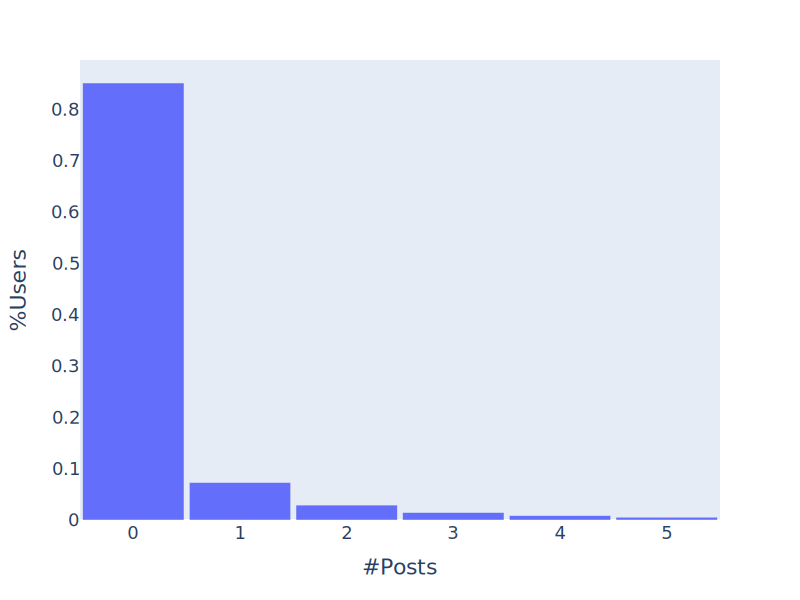

In [16]:
'''
    Distribution of number of future posts made by StackOverflow newcomers.
'''
X_MAX_RANGE = 5

fig = px.bar(nc['NumFuturePosts'].value_counts().sort_index() / len(nc.index))

fig.update_xaxes(
    range=[-0.5, X_MAX_RANGE + 0.5],
    showgrid=False
)

fig.update_yaxes(
    showgrid=False
)

fig.update_layout(
    bargap=0.05,
    showlegend=False,
    xaxis_title = '#Posts',
    yaxis_title = '%Users',
    font_family='Calibri',
    font_size=18,
    height=600,
    width=800
)

fig.show('svg')
fig.write_image('figs/future-post-dist.png', scale=3)

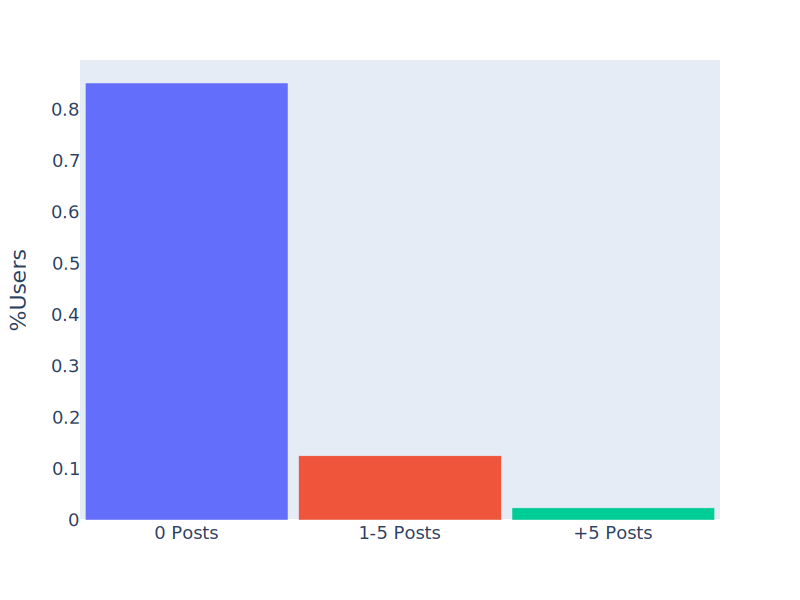

In [17]:
'''
    Number of users who posted X number of times according to bins.
'''
bins = nc['NumFuturePosts'].value_counts().sort_index()

bins = pd.DataFrame.from_dict({
    '0 Posts': bins[0] / len(nc.index),
    '1-5 Posts': bins[1:5].sum() / len(nc.index),
    '+5 Posts': bins[5:].sum() / len(nc.index)
}, orient='index')

fig = px.bar(bins, color=bins.index)

fig.update_xaxes(
    showgrid=False
)

fig.update_yaxes(
    showgrid=False
)

fig.update_layout(
    bargap=0.05,
    showlegend=False,
    xaxis_title = '',
    yaxis_title = '%Users',
    font_family='Calibri',
    font_size=18,
    height=600,
    width=800
)

fig.show('svg')
fig.write_image('figs/future-post-bins.png', scale=3)

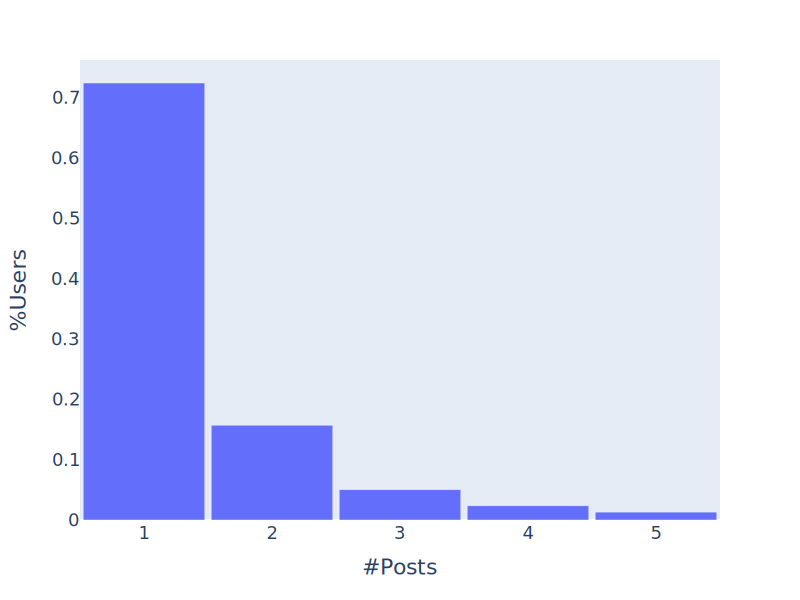

In [18]:
'''
    Distribution of number of initial posts made by StackOverflow newcomers.
'''
X_MAX_RANGE = 5

fig = px.bar(nc['NumInitialPosts'].value_counts().sort_index() / len(nc.index))

fig.update_xaxes(
    range=[0.5, X_MAX_RANGE + 0.5],
    showgrid=False
)

fig.update_yaxes(
    showgrid=False
)

fig.update_layout(
    bargap=0.05,
    showlegend=False,
    xaxis_title = '#Posts',
    yaxis_title = '%Users',
    font_family='Calibri',
    font_size=18,
    height=600,
    width=800
)

fig.show('svg')
fig.write_image('figs/initial-post-dist.png', scale=3)

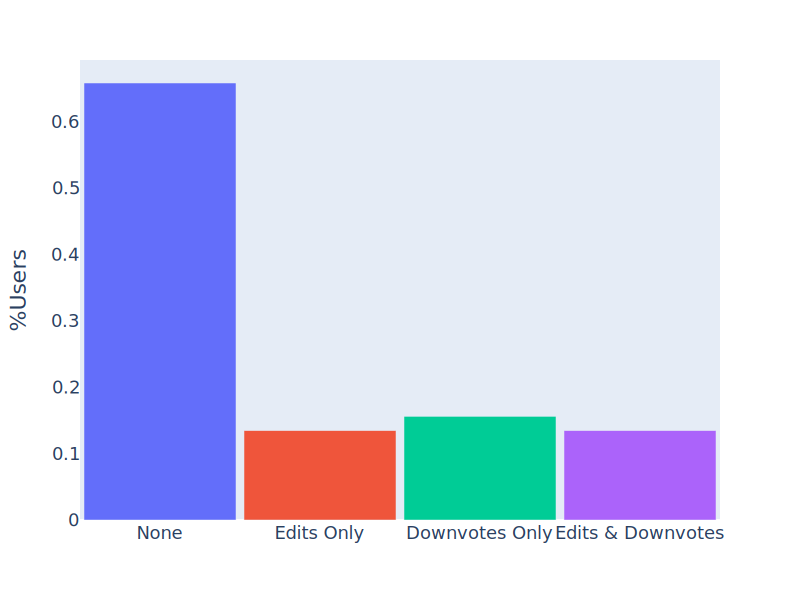

In [21]:
'''
    Edit and downvote splits.
'''
bins = pd.DataFrame.from_dict({
    'None': len(nc[(nc['TotalDownVotes'] == 0) & (nc['TotalSuggestedEdits'] == 0)].index) / len(nc.index),
    'Edits Only': len(nc[(nc['TotalDownVotes'] == 0) & (nc['TotalSuggestedEdits'] > 0)].index) / len(nc.index),
    'Downvotes Only': len(nc[(nc['TotalDownVotes'] > 0) & (nc['TotalSuggestedEdits'] == 0)].index) / len(nc.index),
    'Edits & Downvotes': len(nc[(nc['TotalDownVotes'] == 0) & (nc['TotalSuggestedEdits'] > 0)].index) / len(nc.index)
}, orient='index')

fig = px.bar(bins, color=bins.index)

fig.update_xaxes(
    showgrid=False
)

fig.update_yaxes(
    showgrid=False
)

fig.update_layout(
    bargap=0.05,
    showlegend=False,
    xaxis_title = '',
    yaxis_title = '%Users',
    font_family='Calibri',
    font_size=18,
    height=600,
    width=800
)

fig.show('svg')
fig.write_image('figs/downvote-edit-prop-bins.png', scale=3)

## Utility Functions

In [6]:
def log_odds(model):
    odds = model.conf_int()
    odds['Odds Ratio'] = model.params
    odds.columns = ['5%', '95%', 'Odds Ratio']
    odds = np.exp(odds)

    return odds

## All Posts Logistic Regression

In [7]:
'''
    Logistic regression over all posts (i.e. questions and answers).
'''
model = smf.logit(
    formula='Retained ~ AvgUpVotes + AvgDownVotes + AvgOtherPositive + AvgOtherNegative ' \
        '+ Lurking',
    data=nc
).fit(disp=False) # Turning off annoying print statement.

display(nc['Retained'].astype(bool).value_counts() / len(nc.index))
display(model.summary())
display(log_odds(model))
print(f'Ran on {len(nc.index):,} newcomers.')

False    0.851341
True     0.148659
Name: Retained, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:               173511
Model:                          Logit   Df Residuals:                   173505
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Mar 2022   Pseudo R-squ.:               0.0009023
Time:                        21:17:05   Log-Likelihood:                -72874.
converged:                       True   LL-Null:                       -72940.
Covariance Type:            nonrobust   LLR p-value:                 1.076e-26
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.7643      0.008   -209.887      0.000      -1.781      -1.748
AvgUpVotes           0.0104      0.003      3.165      0.002       0.004       0.017
AvgDownVotes        -0.0588      0.012     -5.064      0.000      -0.082      -0.036
AvgOtherPositive     0.1614      0.023      7.065      0.000       0.117       0.206
AvgOtherNegative    -0.2649      0.115     -2.313      0.021      -0.489      -0.040
Lurking           4.576e-05   1.19e-05      3.843      0.000    2.24e-05    6.91e-05
====================================================================================
"""

,5%,95%,Odds Ratio
Intercept,0.168511,0.174156,0.171310
AvgUpVotes,1.003983,1.017045,1.010492
AvgDownVotes,0.921697,0.964610,0.942909
AvgOtherPositive,1.123688,1.228958,1.175145
AvgOtherNegative,0.612939,0.960410,0.767251
Lurking,1.000022,1.000069,1.000046


Ran on 173,511 newcomers.


## Answered Questions Logistic Regression

In [8]:
data = nc[(nc['NumQuestions'] > 0) & (nc['AvgNumAnswers'] > 0)]

model = smf.logit(
    formula='Retained ~ AvgTopAnswererRep + AvgTopAnswererAge ' \
        '+ AvgUpVotes + AvgDownVotes + AvgOtherPositive + AvgOtherNegative ' \
        '+ Lurking + AvgViewCount + AvgNumAnswers',
    data=data
).fit(disp=False)

display(data['Retained'].astype(bool).value_counts() / len(data.index))
display(model.summary())
display(log_odds(model))
print(f"Ran on {len(data.index):,} newcomers.")

False    0.832198
True     0.167802
Name: Retained, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:               103038
Model:                          Logit   Df Residuals:                   103028
Method:                           MLE   Df Model:                            9
Date:                Mon, 28 Mar 2022   Pseudo R-squ.:                0.002099
Time:                        21:17:06   Log-Likelihood:                -46515.
converged:                       True   LL-Null:                       -46613.
Covariance Type:            nonrobust   LLR p-value:                 2.690e-37
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5671      0.021    -74.776      0.000      -1.608      -1.526
AvgTopAnswererRep  2.736e-07   6.56e-08      4.169      0.000    1.45e-07    4.02e-07
AvgTopAnswererAge -3.687e-05   7.77e-06     -4.742      0.000   -5.21e-05   -2.16e-05
AvgUpVotes            0.0110      0.007      1.663      0.096      -0.002       0.024
AvgDownVotes         -0.1311      0.013    -10.178      0.000      -0.156      -0.106
AvgOtherPositive      0.0396      0.030      1.301      0.193      -0.020       0.099
AvgOtherNegative      0.1923      0.140      1.378      0.168      -0.081       0.466
Lurking            6.913e-05   1.68e-05      4.123      0.000    3.63e-05       0.000
AvgViewCount       1.409e-05   3.71e-06      3.795      0.000    6.81e-06    2.14e-05
AvgNumAnswers         0.0117      0.012      0.943      0.346      -0.013       0.036
=====================================================================================
"""

,5%,95%,Odds Ratio
Intercept,0.200245,0.217391,0.208642
AvgTopAnswererRep,1.000000,1.000000,1.000000
AvgTopAnswererAge,0.999948,0.999978,0.999963
AvgUpVotes,0.998044,1.024214,1.011044
AvgDownVotes,0.855227,0.899530,0.877099
AvgOtherPositive,0.980137,1.104374,1.040403
AvgOtherNegative,0.921992,1.593288,1.212022
Lurking,1.000036,1.000102,1.000069
AvgViewCount,1.000007,1.000021,1.000014
AvgNumAnswers,0.987426,1.036767,1.011796


Ran on 103,038 newcomers.


## Edited Posts Logistic Regression

In [9]:
data = nc[nc['TotalSuggestedEdits'] > 0]

model = smf.logit(
    formula='Retained ~ AvgEditorRep + AvgEditorAge ' \
        '+ AvgUpVotes + AvgDownVotes + AvgOtherPositive + AvgOtherNegative ' \
        '+ AvgNumEdits + Lurking',
    data=data
).fit(disp=False)

display(data['Retained'].astype(bool).value_counts() / len(data.index))
display(model.summary())
display(log_odds(model))
print(f"Ran on {len(data.index):,} newcomers.")

# Notes: AvgOtherNegative and AvgNumEdits seem abnormally impactful towards
#   retention.

False    0.835842
True     0.164158
Name: Retained, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:                32219
Model:                          Logit   Df Residuals:                    32210
Method:                           MLE   Df Model:                            8
Date:                Mon, 28 Mar 2022   Pseudo R-squ.:                 0.03886
Time:                        21:17:06   Log-Likelihood:                -13827.
converged:                       True   LL-Null:                       -14386.
Covariance Type:            nonrobust   LLR p-value:                4.978e-236
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5728      0.041    -13.806      0.000      -0.654      -0.491
AvgEditorRep      7.866e-08   6.11e-06      0.013      0.990   -1.19e-05    1.21e-05
AvgEditorAge     -4.506e-05   1.61e-05     -2.803      0.005   -7.66e-05   -1.36e-05
AvgUpVotes           0.0182      0.005      3.455      0.001       0.008       0.029
AvgDownVotes        -0.0060      0.025     -0.237      0.812      -0.056       0.044
AvgOtherPositive     0.0631      0.055      1.148      0.251      -0.045       0.171
AvgOtherNegative    -0.5023      0.299     -1.677      0.093      -1.089       0.085
AvgNumEdits         -1.3575      0.043    -31.504      0.000      -1.442      -1.273
Lurking           9.647e-05   3.07e-05      3.137      0.002    3.62e-05       0.000
====================================================================================
"""

,5%,95%,Odds Ratio
Intercept,0.519913,0.611731,0.563957
AvgEditorRep,0.999988,1.000012,1.000000
AvgEditorAge,0.999923,0.999986,0.999955
AvgUpVotes,1.007916,1.028970,1.018388
AvgDownVotes,0.945776,1.044677,0.993997
AvgOtherPositive,0.956309,1.186456,1.065185
AvgOtherNegative,0.336491,1.088309,0.605150
AvgNumEdits,0.236478,0.279990,0.257316
Lurking,1.000036,1.000157,1.000096


Ran on 32,219 newcomers.
